In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

from skimage import data, io, filters
from skimage.io import imread_collection

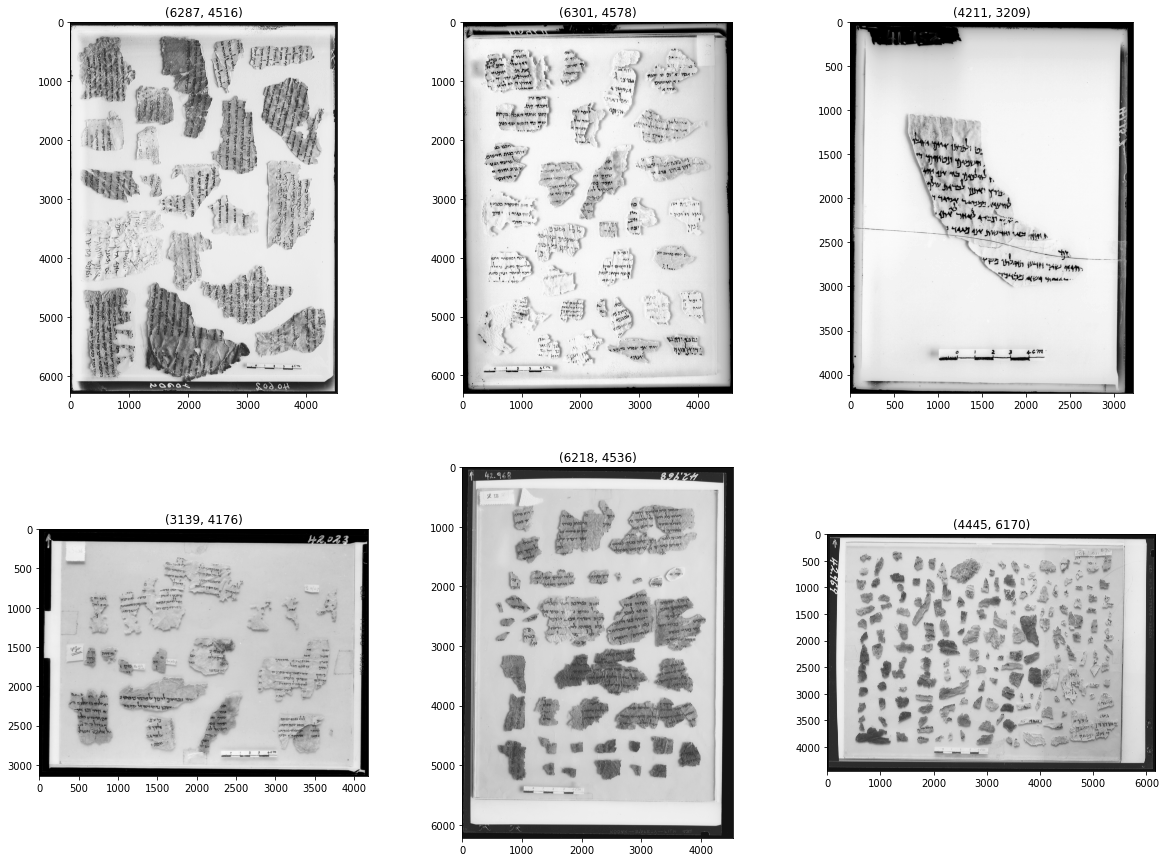

In [2]:
#read data


images = imread_collection('data/*')

num_of_images=len(images)
plt.figure(figsize=(20, 15))
for (image,i) in zip (images,range(1,num_of_images+1)):
    # edges = filters.scharr(image)
    
    plt.subplot(int(np.ceil(num_of_images/3)),3,i)
    plt.title(image.shape)
    plt.imshow(image,cmap="gray")
     

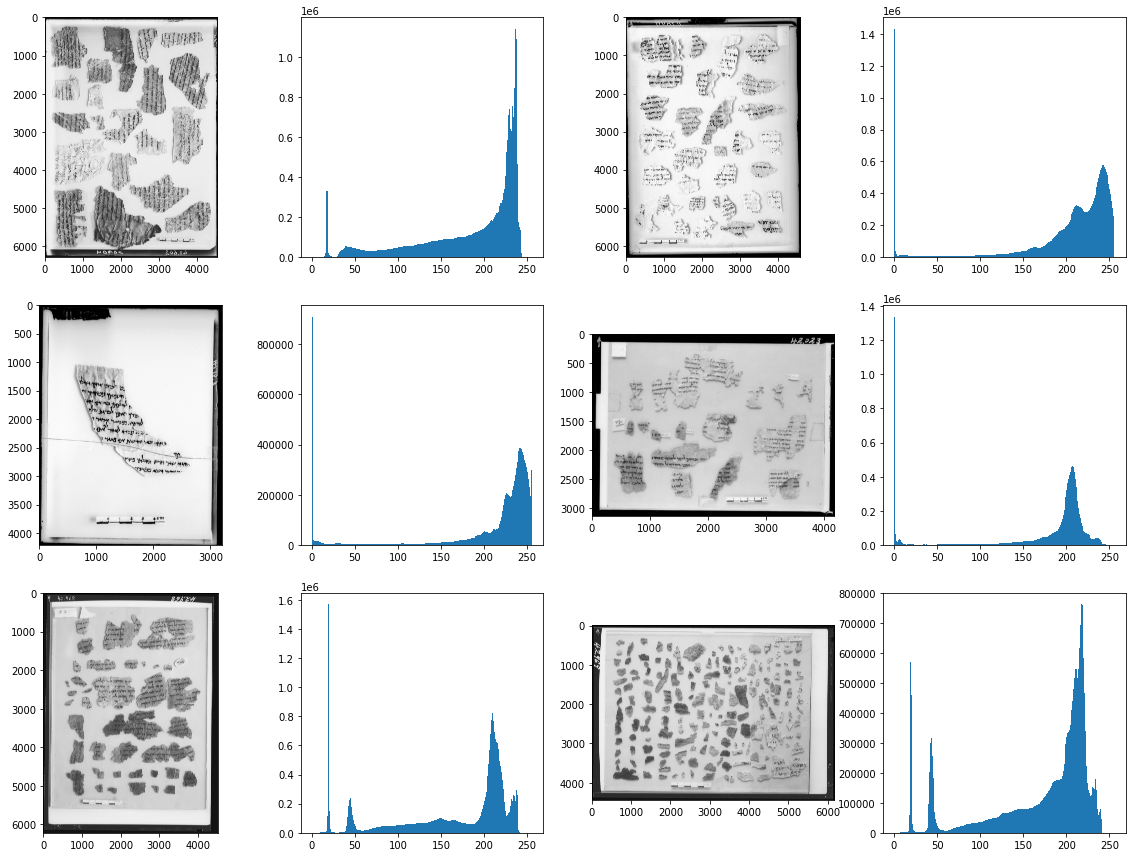

In [4]:
#show histogrem

plt.figure(figsize=(20, 15))

for (image,i) in zip (images,range(1,num_of_images+1)):
    
    plt.subplot(int(np.ceil(num_of_images/2)),4,2*i-1)
    plt.imshow(image,cmap='gray')
    plt.subplot(int(np.ceil(num_of_images/2)),4,2*i)
    plt.hist(image.ravel(),256,[0,256]); 

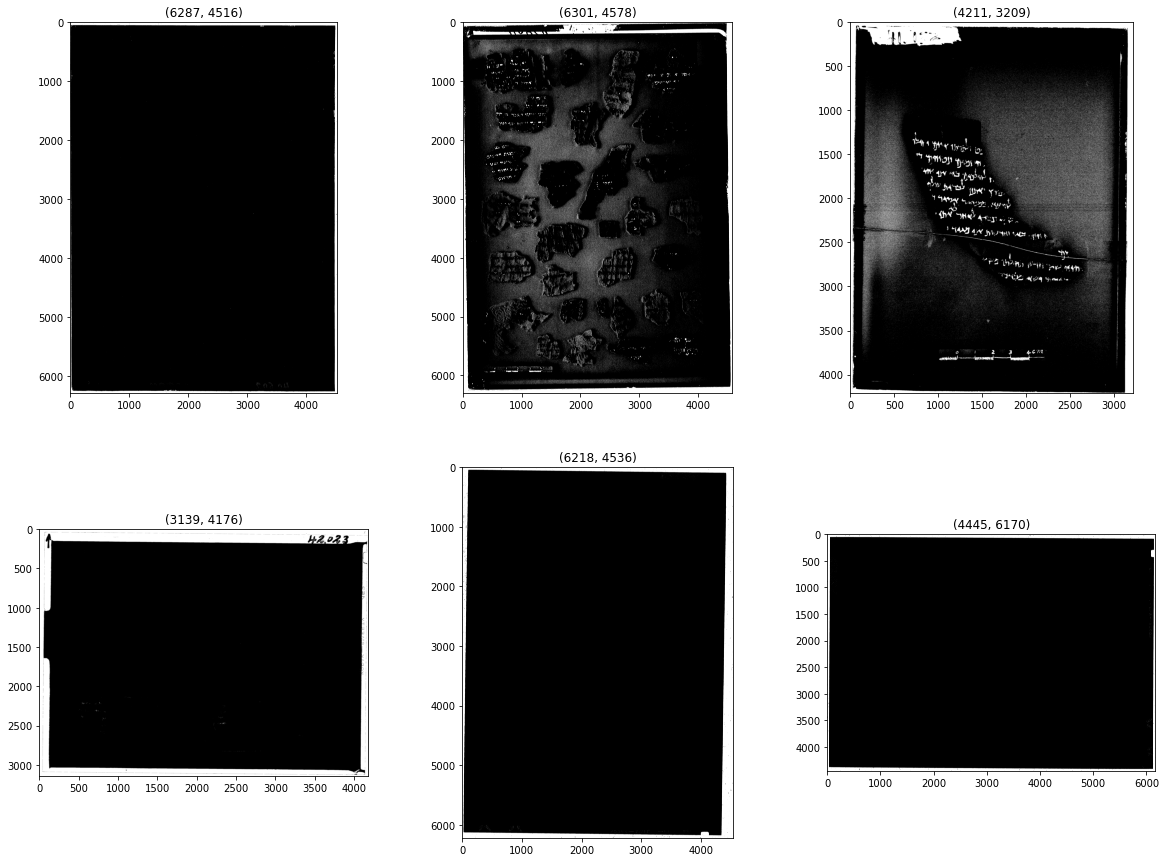

In [7]:
th_back_black=0
th_back_white=0

th_back_black=0

plt.figure(figsize=(20, 15))
new_images=images
for (image,i) in zip (images,range(1,num_of_images+1)):
    image[image<25]=1
    image[image>250]=1
    image[image>1]=0
    plt.subplot(int(np.ceil(num_of_images/3)),3,i)
    plt.title(image.shape)
    plt.imshow(image,cmap="gray")

In [8]:
def find_edges(img):

    kernel7 = np.ones((7, 7)).astype(np.uint8)
    kernel7[0:2,0:2] = [[0, 0], [0, 1]]
    kernel7[0:2,5:7] = [[0, 0], [1, 0]]
    kernel7[5:7,0:2] = [[0, 1], [0, 0]]
    kernel7[5:7,5:7] = [[1, 0], [0, 0]]

    # show([kernel7], ['Morph Kernel'], 1)

    # get edges by subtracting dilation and erosion
    dilate7 = cv2.dilate(img, kernel7, iterations=1)
    erode7 = cv2.erode(img, kernel7, iterations=1)
    th, dst = cv2.threshold(dilate7-erode7, 50, 255, cv2.THRESH_BINARY)

    return dst

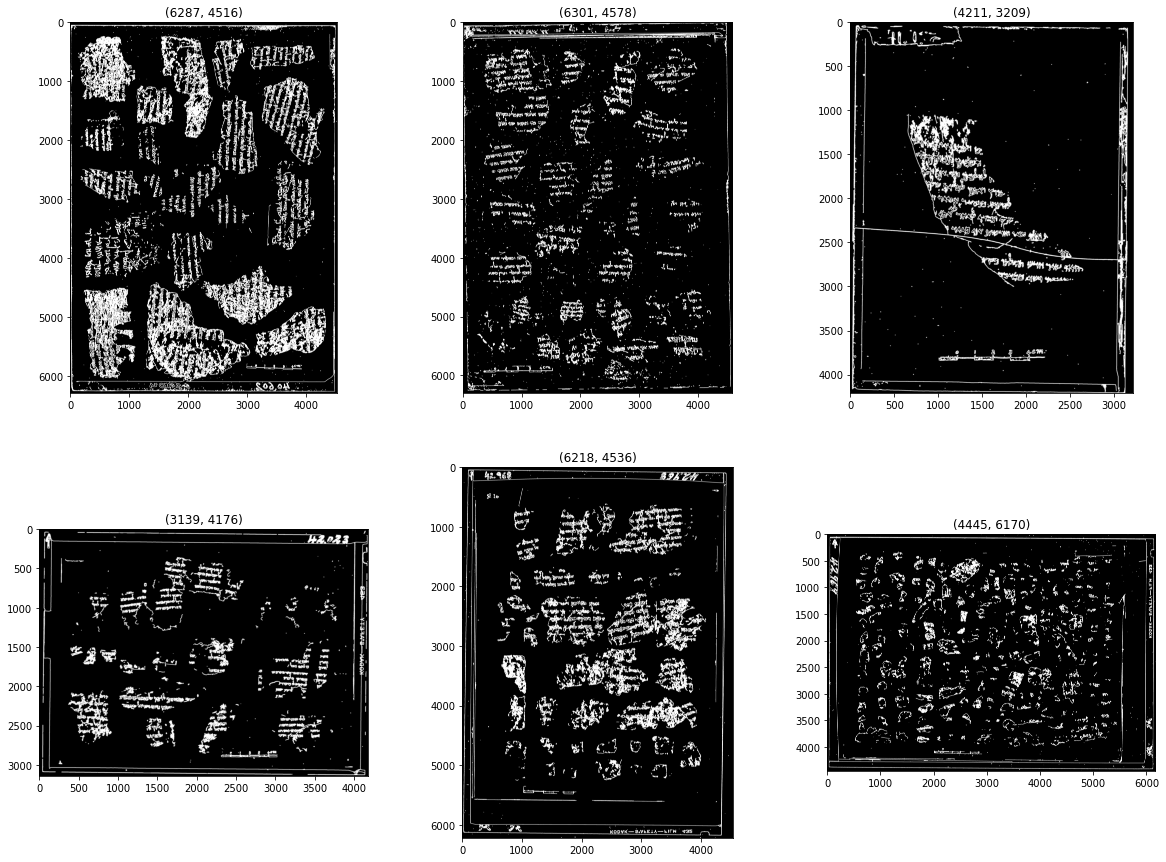

In [9]:
plt.figure(figsize=(20, 15))
for (image,i) in zip (images,range(1,num_of_images+1)):
    
    edges = cv2.Canny(image,50,256)
    plt.subplot(int(0.5+num_of_images/3),3,i)
    plt.title(image.shape)
    plt.imshow(find_edges(edges),cmap='gray')